Dataset already downloaded
Loading existing dataset 'coco-2014'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



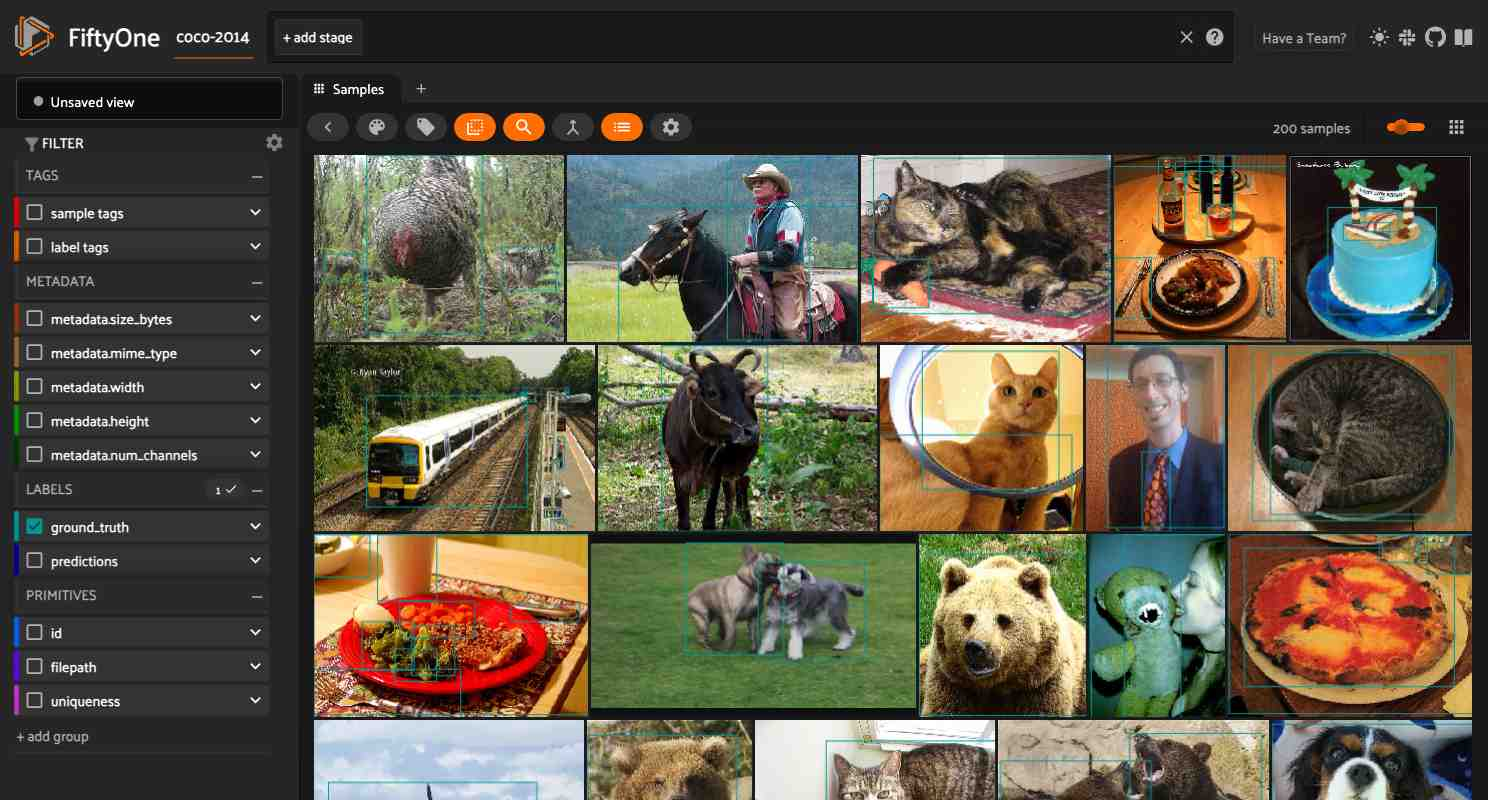

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F

# Step 1: Load your data into FiftyOne

coco_dataset2 = foz.load_zoo_dataset(
    "quickstart", dataset_name="coco-2014"
)
# coco_dataset.persistent = True

session = fo.launch_app(coco_dataset2)


In [2]:
coco_dataset2.evaluate_detections(
    "predictions", gt_field="ground_truth", eval_key="eval"
)


Evaluating detections...
 100% |█████████████████| 200/200 [11.3s elapsed, 0s remaining, 12.8 samples/s]      


In [5]:

# Step 2: Locate a subset of your data requiring annotation

# Create a view that contains only high confidence false positive model
# predictions, with samples containing the most false positives first
most_fp_view = (
    coco_dataset2
    .filter_labels("predictions", (F("confidence") > 0.8) & (F("eval") == "fp"))
    .sort_by(F("predictions.detections").length(), reverse=True)
)

# Retrieve the sample with the most high confidence false positives
sample_id = most_fp_view.first().id
view = coco_dataset2.select(sample_id)

session = fo.launch_app(view)


In [8]:

# Step 3: Send samples to Label Studio

# A unique identifier for this run
anno_key = "labelstudio_basic_recipe2"

label_schema = {
    "new_ground_truth": {
        "type": "detections",
        "classes": coco_dataset2.distinct("ground_truth.detections.label"),
    },
}

view.annotate(
    anno_key,
    backend="labelstudio",
    label_schema=label_schema,
    launch_editor=True,
    url="http://localhost:8080",
)
print(coco_dataset2.get_annotation_info(anno_key))

# Step 4: Perform annotation in Label Studio and save the tasks

The backend 'labelstudio' does not support attributes. Provided attributes will be ignored.
Please enter your API key.
You can avoid this in the future by setting your `FIFTYONE_LABELSTUDIO_API_KEY` environment variable
Uploading media to Label Studio...
Computing metadata...
 100% |█████████████████████| 1/1 [18.0ms elapsed, 0s remaining, 55.5 samples/s] 
Upload complete
Launching editor at 'http://localhost:8080/projects/2'...
{
    "key": "labelstudio_basic_recipe2",
    "version": "0.23.8",
    "timestamp": "2024-04-23T06:57:44.772629",
    "config": {
        "cls": "fiftyone.utils.labelstudio.LabelStudioBackendConfig",
        "type": "annotation",
        "method": "labelstudio",
        "name": "labelstudio",
        "label_schema": {
            "new_ground_truth": {
                "type": "detections",
                "classes": [
                    "airplane",
                    "apple",
                    "backpack",
                    "banana",
                    "ba

In [10]:
import fiftyone as fo

anno_key = "labelstudio_basic_recipe2"

# Step 5: Merge annotations back into FiftyOne dataset

dataset = fo.load_dataset("quickstart")
dataset.load_annotations(anno_key)

# Load the view that was annotated in the App
view = dataset.load_annotation_view(anno_key)
session = fo.launch_app(view=view)


ValueError: Dataset 'quickstart' not found

In [ ]:

# Step 6: Cleanup

# Delete tasks from Label Studio
results = dataset.load_annotation_results(anno_key)
results.cleanup()

# Delete run record (not the labels) from FiftyOne
dataset.delete_annotation_run(anno_key)